In [1]:
using JLD2, FileIO, FITSIO, FITSTables, DataFrames, CSV, PyPlot, PyCall
LogNorm = pyimport("matplotlib.colors").LogNorm
include("get_lamost_spectra.jl")
include("fitsdf.jl")
;

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


### load battery, dr2, praesepe sets

In [260]:
lamost = FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5v3-designations-coords-gaia.fits")
lamost.G = @. lamost.phot_bp_mean_mag + 5log10(max(lamost.parallax, 0)/1000) + 5;

tenth = Set(CSV.read("one_tenth_of_LAMOST_dr5.csv").obsid);

battery = DataFrame()
FITS("../cats/the-battery-stars.rc.fits") do hdus
    battery.fn = read(hdus[2], "lamost_id")
    battery.ra = read(hdus[2], "ra")
    battery.dec = read(hdus[2], "dec")
end
battery = join(battery, lamost, on=[:ra, :dec]);
#battery = Set(battery.obsid) ∩ tenth

dr2 = FITS("../cats/LAMOST-dr2-stellar.fits.gz") do hdus
    Set(read(hdus[2], "obsid"))
end

pleiades = CSV.read("../cats/LAMOST-dr4v2-pleiades-members.csv")
pleiades = Set(pleiades.designation) ;

In [261]:
pleiades

Set(["J034456.55+242557.3", "J034327.14+252315.1", "J034042.56+254219.6", "J034459.13+220156.8", "J035408.92+242000.7", "J034343.10+233541.2", "J034513.92+263518.2", "J034404.48+255122.7", "J034640.24+232951.8", "J034508.20+261733.0"  …  "J034441.87+222753.8", "J034605.58+234525.5", "J034113.81+232305.2", "J034203.93+222536.8", "J034602.75+234414.6", "J034522.18+232818.1", "J034507.62+215945.4", "J034714.80+252218.6", "J035922.89+223416.9", "J034012.01+253832.1"])

### load test results

In [3]:
dfs = Dict()
for (k, fn) in [#("ds", "distributed_topsnr_1000_test.classified.fits"),
                #("ds10k", "distributed_topsnr_10000_test.classified.fits"),
                #("d", "distributed_test.classified.fits")]
                #("r", "random_test.classified.fits"),
                ("r", "random_30000_test.classified.fits")]
                #("s", "topsnr_test.classified.fits")]
    dfs[k] = join(fitsdf(fn, 2), lamost[:, [:designation, :teff, :feh, :logg, :phot_g_mean_mag, :bp_rp, :snrr, :G]], kind=:left, on=:designation)
end
df = dfs["r"];

In [4]:
for col in [:teff, :logg, :phot_g_mean_mag, :bp_rp, :snrr, :G]
    df[ismissing.(df[:, col]), col] .= NaN
end
;

### compare basic stats

In [5]:
for (k, df) in dfs
    println("$k")
    df.inbat = map(eachrow(df)) do row
        row.designation in Set(battery.designation)
    end

    df.oldcat = map(eachrow(df)) do row
        (row.obsid in dr2) && (row.logg .< 3)
    end   
    
    df.couldflag = df.EEW_err .< 0.2/3
    df.flagged = df.isline .& (df.EEW .> 0.2) .& df.couldflag
    println(sum(df.flagged))
    
    df.delta_loss = map(df.loss) do loss
        minimum(loss[2:end]) - loss[1]
    end
    df.oldflagged = (df.delta_loss .> 25) .& (df.EEW .> 0)
    
    
    println("fraction of all spectra that get flagged: ", mean(df.flagged), " (", sum(df.flagged), ")")
    println("faction too noisy to be flagged: $(mean(.! df.couldflag)) ($(sum(.! df.couldflag)))")
    #println("flagged $(sum(df[df.oldcat, :flagged])) including $(sum(df[df.oldcat .& df.couldflag, :flagged] .& df[df.oldcat .& df.couldflag, :inbat])) of $(sum(df[df.oldcat .& df.couldflag, :inbat])) in flaggable battery for DR2 giants")
    println()
end

r
765
fraction of all spectra that get flagged: 0.001431000521894308 (765)
faction too noisy to be flagged: 0.28344472690337097 (151527)



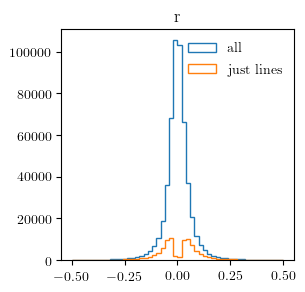

In [7]:
for (k, df) in dfs
    figure(figsize=(3,3))
    r = (-0.5,0.5)
    plt.hist(df.EEW, density=false, range=r, bins=50, histtype="step", label="all")
    plt.hist(df.EEW[df.isline], density=false, range=r, bins=50, histtype="step", label="just lines")
    title(k)
    #println(Set(df.designation[df.match]) ∩ pleiades)
    #ylabel("prob density")
    #xlabel("best fit EEW")
    #plt.hist(df.EEW[[d in pleiades for d in df.designation]], density=true, range=r, bins=25, histtype="step", label="pleiades")
    legend()
end

### TODO what up with this spectrum?

In [29]:
obsid = df[argmax(df.EEW .* (df.isline)), :obsid]
download_lamost_spectra([obsid])
wl, f, ivar = load_lamost_spectrum(obsid)
figure(figsize=(12, 3))
mask = 6680 .< wl .< 6730
plot(wl[mask], f[mask])
axvline(li_vac)

of 1 spectra, 0 need to be downloaded


UndefVarError: UndefVarError: li_vac not defined

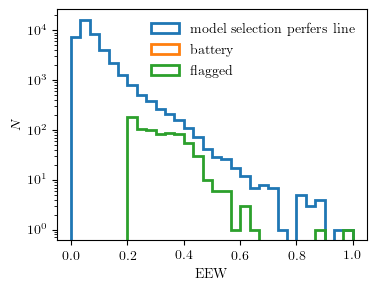

PyObject Text(0.5, 22.299550986642963, 'EEW')

In [8]:
figure(figsize=(4,3))
df = dfs["r"]
plt.hist(df[df.isline, :EEW], bins=30, range=(0, 1), histtype="step", label="model selection perfers line", lw=2)
plt.hist(df[df.inbat, :EEW], bins=30, range=(0, 1), histtype="step", label="battery", lw=2)
plt.hist(df[df.flagged, :EEW], bins=30, range=(0, 1), histtype="step", label="flagged", lw=2)
legend()
plt.yscale("log")
ylabel(L"N")
#xlabel(L"\Delta \chi^2")
xlabel("EEW")

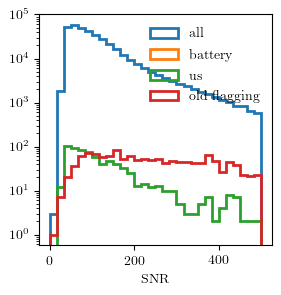

PyObject Text(0.5, 22.299550986642963, 'SNR')

In [62]:
include("../cats/human_readable_names.jl")
#for (m, df) in dfs
figure(figsize=(3,3))
#df = dfs["r"]
col=:snrr
range=[0,500]
plt.hist(df[df.couldflag, col], histtype="step", lw=2, label="all", range=range, bins=30)
plt.hist(df[df.inbat, col], histtype="step", lw=2, label="battery", range=range, bins=30)
plt.hist(df[df.flagged, col], histtype="step", lw=2, label="us", range=range, bins=30)
plt.hist(df[df.oldflagged, col], histtype="step", lw=2, label="old flagging", range=range, bins=30)
yscale("log")
legend()
xlabel("SNR")
#end

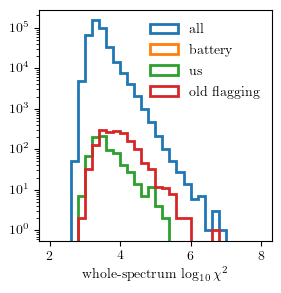

PyObject Text(0.5, 24.64571384732384, 'whole-spectrum $\\log_{10} \\chi^2$')

In [63]:
include("../cats/human_readable_names.jl")
#for (m, df) in dfs
figure(figsize=(3,3))
#df = dfs["r"]
col=:best_fit_chi2
range=[2, 8]
plt.hist(log10.(df[df.couldflag, col]), histtype="step", lw=2, label="all", range=range, bins=30)
plt.hist(log10.(df[df.inbat, col]), histtype="step", lw=2, label="battery", range=range, bins=30)
plt.hist(log10.(df[df.flagged, col]), histtype="step", lw=2, label="us", range=range, bins=30)
plt.hist(log10.(df[df.oldflagged, col]), histtype="step", lw=2, label="old flagging", range=range, bins=30)
yscale("log")
legend()
xlabel(L"whole-spectrum $\log_{10} \chi^2$")
#end

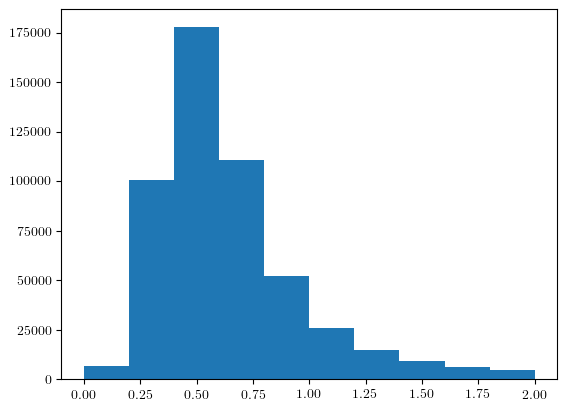

In [66]:
hist(df.best_fit_chi2 ./ length(wl_grid), range=[0,2]);

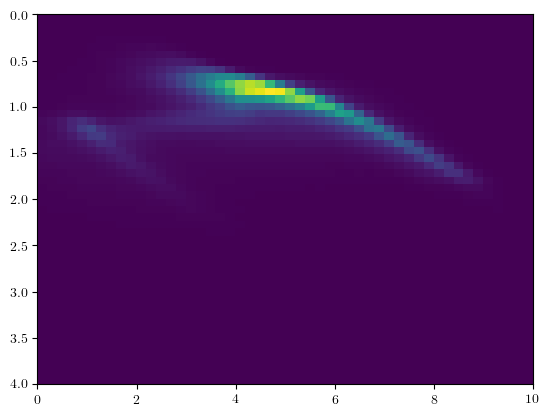

(4.0, 0.0)

In [134]:
plt.hist2d(lamost.G, lamost.bp_rp, range=[[0, 10], [0, 4]], bins=50, zorder=-1)
ylim(reverse(ylim()))

# lithium science

In [242]:
using PyCall
py"""
import sys
sys.path.insert(0, ".")
"""
rmm = pyimport("read_mist_models")
eeps = []
cols = ["phase", "Gaia_G_DR2Rev", "Gaia_BP_DR2Rev", "Gaia_RP_DR2Rev", "log_Teff", "log_g", "star_age", "Z_surf"]

for M in [0.5, 0.8, 1, 1.5, 2], feh in ["p0.00"]#["m0.50", "p0.00", "p0.50"]
    Mstr = lpad(Int(M*10000), 7, '0')
    eep = rmm.EEPCMD("../cats/MIST/MIST_v1.2_feh_$(feh)_afe_p0.0_vvcrit0.4_CMDEEPS/$(Mstr)M.track.eep.cmd")
    df = DataFrame([Symbol(c)=>get(eep.eepcmds, c) for c in cols]...)
    df.BP_RP = df.Gaia_BP_DR2Rev .- df.Gaia_RP_DR2Rev
    rename!(df, :Gaia_G_DR2Rev=>:G)
    push!(eeps, (M, feh, df))
end

In [253]:
function overplot_eep(eeps, xcol, ycol)
    ls = Dict("m0.50"=>":", "p0.00"=>"-", "p0.50"=>"--")
    for (M, feh, eep) in eeps
        mask = 0 .<= eep.phase .< 4
        xs = eep[mask, xcol]
        ys = eep[mask, ycol]
        plot(xs, ys, ls = ls[feh], c="k", alpha=0.7)
        if feh == "p0.00"
            text(xs[1], ys[1]+0.2, LaTeXString("\$$(M) M_\\odot\$"), va="top", ha="center", color="k", size=12)
        end
    end
end

overplot_eep (generic function with 1 method)

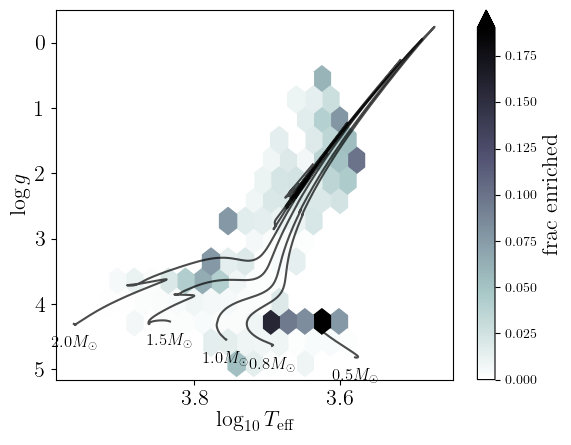

In [305]:
mask = df.EEW_err .< 0.1/3
censoredmean(f) = length(f) > 10 ? mean(f) : NaN
hexbin(log10.(df.teff[mask]), df.logg[mask], C=df.EEW[mask] .> 0.1, reduce_C_function=censoredmean, gridsize=15, cmap="bone_r")#, extent=[4.1, 3.4, 0, 5.1])
colorbar(extend="max").set_label(label="frac enriched",size=16)
xlabel(L"\log_{10} T_\mathrm{eff}", fontsize=16)
ylabel(L"\log g", fontsize=16)
gca().tick_params(labelsize=16)
gca().invert_yaxis()
gca().invert_xaxis()
overplot_eep(eeps, :log_Teff, :log_g)
savefig("../../Desktop/mstofrac.pdf")

In [224]:
mindeltaL = (l-> minimum(l[2:end] .- l[1])).(df.loss);

534591-element Array{Float64,1}:
  -0.7311557260471991 
   0.3939465415157475 
   0.8628140558044333 
   1.5947401266060073 
   1.5978381420524759 
  10.176096158371983  
  -7.3889704465613315 
   0.2291258940994214 
 -10.608014102305347  
  -1.9542210505012954 
   6.347087607211803  
  -3.9699954503318455 
  -2.8207628354136434 
   ⋮                  
  -5.5422361300909175 
  -0.3604246980987398 
 -12.615442837876808  
   4.100787890330894  
  -0.6711021077775973 
  -0.23573481954586128
  -0.44110890316168705
  -0.15119500870830005
  -0.11573864746224594
  -0.1838724278752938 
   3.0507597609719    
  -1.4664202833919777 

In [309]:
df[(df.EEW .> 0.1) .& (df.EEW_err .< 0.1/3) .& (mindeltaL .> 20) .& df.isline, [:obsid, :snrr, :EEW, :EEW_err]]

,obsid,snrr,EEW,EEW_err
,Int64,Float32⍰,Float64,Float64
1,27904054,108.89,0.422324,0.0192128
2,28215215,226.08,0.248657,0.0108972
3,30011235,148.82,0.384014,0.0151524
4,30015103,141.88,0.308146,0.016774
5,34214009,93.04,0.229122,0.0279905
6,36208062,173.92,0.322995,0.023318
7,244007122,93.6,0.298476,0.0266265
8,247602023,145.16,0.2073,0.016939
9,247607118,140.3,0.436004,0.0172101


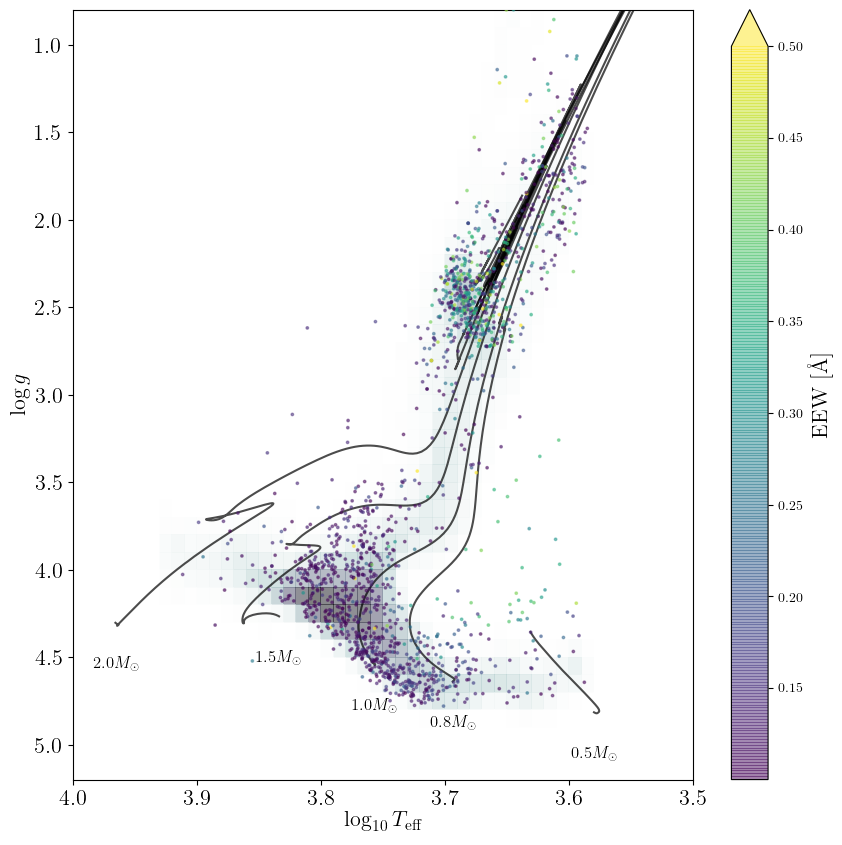

No handles with labels found to put in legend.


In [259]:
include("../cats/human_readable_names.jl")
figure(figsize=(10,10))
mask = df.EEW_err .< 0.1/3
plt.hist2d(log10.(df.teff[mask]), df.logg[mask], cmap="bone_r", bins=50, zorder=-1, alpha=0.5, range=[[3.5,4], [0,5]])
overplot_eep(eeps, :log_Teff, :log_g)
mask = (df.EEW .> 0.1) .& (df.EEW_err .< 0.1/3)
scatter(log10.(df[mask, :teff]), df[mask, :logg], s=3, c=df[mask, :EEW], alpha=0.5, 
        cmap="viridis", vmax=0.5, zorder=10)
gca().invert_yaxis()
gca().invert_xaxis()
colorbar(extend="max").set_label(label=hrname(:EEW),size=16)
legend()
xlim(4, 3.5)
ylim(5.2, 0.8)
xlabel(L"\log_{10} T_\mathrm{eff}", fontsize=16)
ylabel(L"\log g", fontsize=16)
gca().tick_params(labelsize=16)

savefig("../../Desktop/tbcz.pdf")

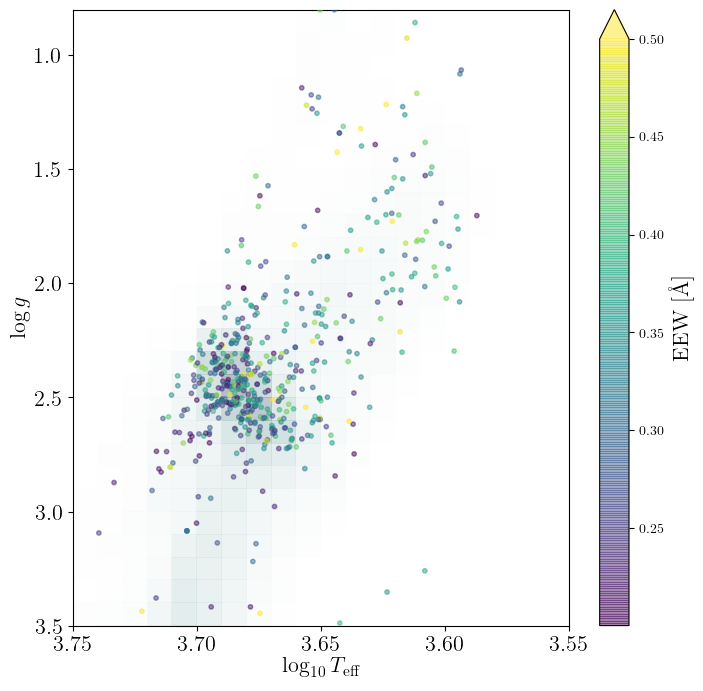

No handles with labels found to put in legend.


In [273]:
figure(figsize=(8,8))
mask = df.EEW_err .< 0.1/3
plt.hist2d(log10.(df.teff[mask]), df.logg[mask], cmap="bone_r", bins=50, zorder=-1, alpha=0.5, range=[[3.5,4], [0,5]])
mask = (df.EEW .> 0.2) .& (df.EEW_err .< 0.2/3)
scatter(log10.(df[mask, :teff]), df[mask, :logg], c=df[mask, :EEW], s=10, alpha=0.5, cmap="viridis", vmax=0.5, zorder=10)
gca().invert_yaxis()
gca().invert_xaxis()
colorbar(extend="max").set_label(label=hrname(:EEW),size=16)
legend()
xlim(3.75, 3.55)
ylim(3.5, 0.8)
xlabel(L"\log_{10} T_\mathrm{eff}", fontsize=16)
ylabel(L"\log g", fontsize=16)
gca().tick_params(labelsize=16)

savefig("../../Desktop/rg.pdf")

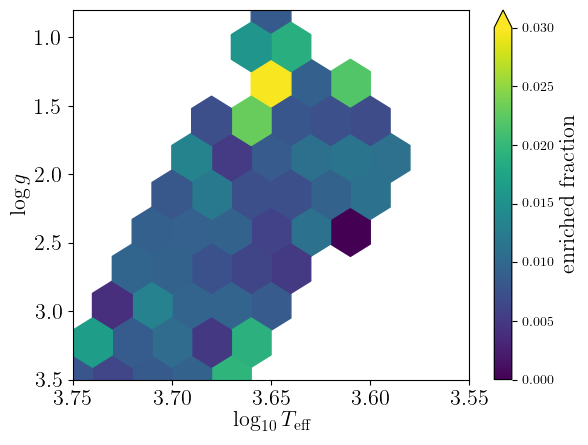

No handles with labels found to put in legend.


In [292]:
#figure(figsize=(8,8))
mask = df.EEW_err .< 0.1/3

censoredmean(f) = length(f) > 100 ? mean(f) : NaN
hexbin(log10.(df.teff[mask]), df.logg[mask], C=df.EEW .> 0.2, reduce_C_function=censoredmean, gridsize=10, extent=[3.55, 3.75, 0.8,3.5], vmax=0.03)
gca().invert_yaxis()
gca().invert_xaxis()
colorbar(extend="max").set_label(label="enriched fraction",size=16)
legend()
xlim(3.75, 3.55)
ylim(3.5, 0.8)
xlabel(L"\log_{10} T_\mathrm{eff}", fontsize=16)
ylabel(L"\log g", fontsize=16)
gca().tick_params(labelsize=16)

savefig("../../Desktop/rg.pdf")

In [289]:
include("bin.jl")
bounds = 3.5:-0.1:09.8
flagged = histogram(bounds, df.logg[(df.EEW .> 0.2) .& (df.EEW_err .< 0.2/3)] )
allstar = histogram(bounds, df.logg[df.EEW_err .< 0.2/3])


DimensionMismatch: DimensionMismatch("dimensions must match")

In [239]:
log10(6650)

3.8228216453031045

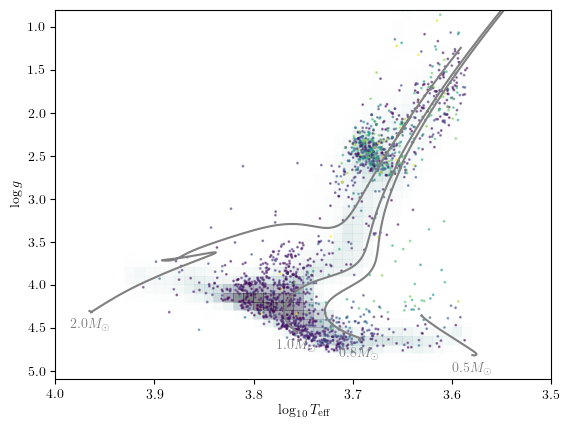

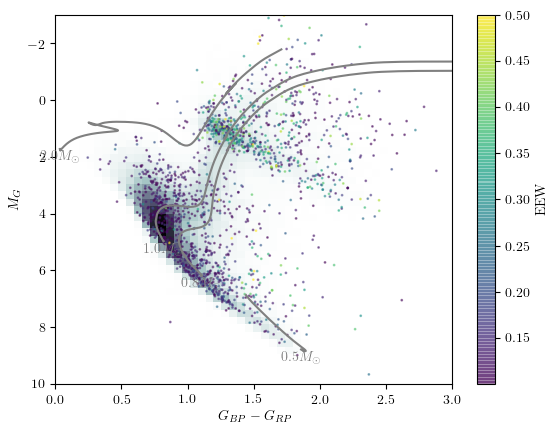

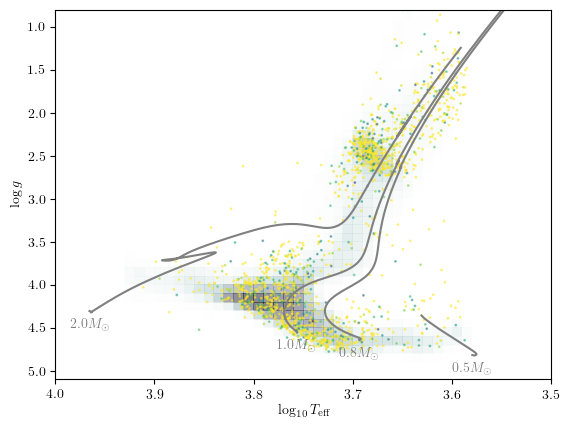

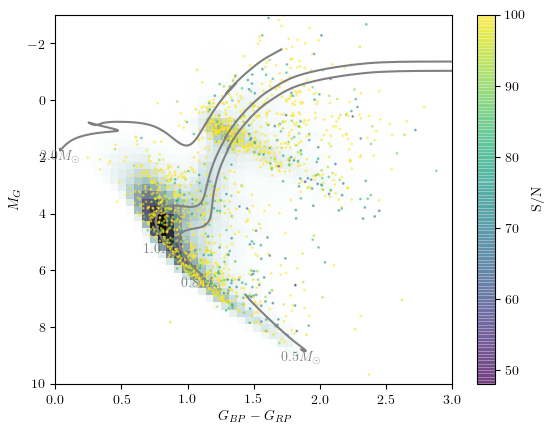

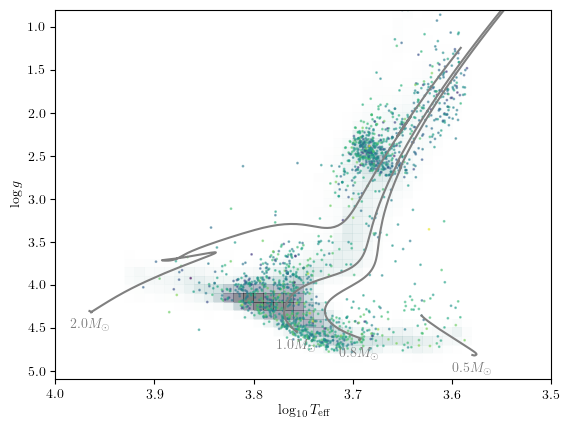

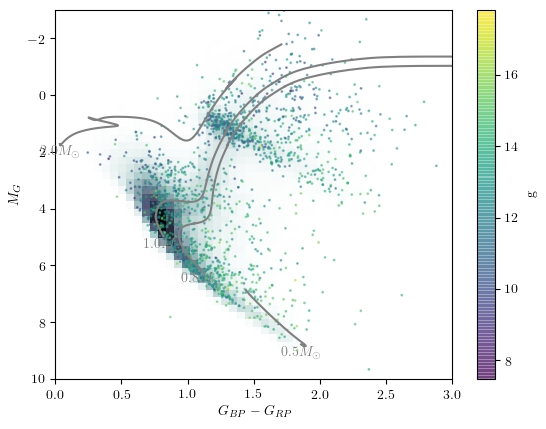

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [164]:
#axs = subplots(1, 2, figsize=(8, 4))[2]
#
#sca(axs[1])
df = dfs["r"]
for (sym, label, vmax) in [(:EEW, "EEW", 0.5), (:snrr, "S/N", 100), (:phot_g_mean_mag, "g", nothing)]
    figure()
    mask = df.EEW_err .< 0.1/3
    plt.hist2d(log10.(df.teff[mask]), df.logg[mask], cmap="bone_r", bins=50, zorder=-1, alpha=0.5, range=[[3.5,4], [0,5]])
    mask = (df.EEW .> 0.1) .& (df.EEW_err .< 0.1/3)
    #mask = df.flagged
    scatter(log10.(df[mask, :teff]), df[mask, :logg], s=1, c=df[mask, sym], alpha=0.5, 
            cmap="viridis", vmax=vmax)
    gca().invert_yaxis()
    gca().invert_xaxis()
    overplot_eep(eeps, :log_Teff, :log_g)
    legend()
    xlim(4, 3.5)
    ylim(5.1, 0.8)
    xlabel(L"\log_{10} T_\mathrm{eff}")
    ylabel(L"\log g")

    #sca(axs[2])
    figure()
    mask = df.EEW_err .< 0.1/3
    plt.hist2d(df.bp_rp[mask], df.G[mask], range=[[0, 3], [-3, 10]], bins=50, cmap="bone_r", zorder=-1)
    #mask = df.flagged
    mask = (df.EEW .> 0.1) .& (df.EEW_err .< 0.1/3)
    scatter(df.bp_rp[mask], df.G[mask], s=1, c=df[mask, sym], alpha=0.5, cmap="viridis", vmax=vmax)
    colorbar(label=label)
    overplot_eep(eeps, :BP_RP, :G)
    #for (M, feh, eep) in eeps
    #    plot(10 .^(get(eep.eeps, "log_Teff")), get(eep.eeps, "log_g"))
    #end
    ylim(reverse(ylim()))
    xlabel(L"G_{BP} - G_{RP}")
    ylabel(L"M_G")
    #
    #tight_layout()
end

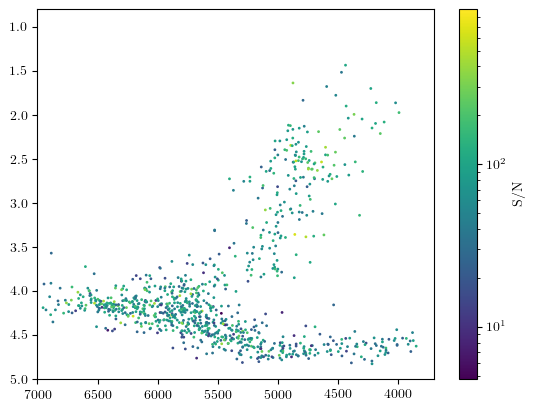

(5.0, 0.8)

In [152]:
inds = rand(1:size(df, 1), 1000)
scatter(df.teff[inds], df.logg[inds], c=df.snrr[inds], s=1, norm=LogNorm())
colorbar(label="S/N")
gca().invert_yaxis()
gca().invert_xaxis()
xlim(7000, 3700)
ylim(5, 0.8)

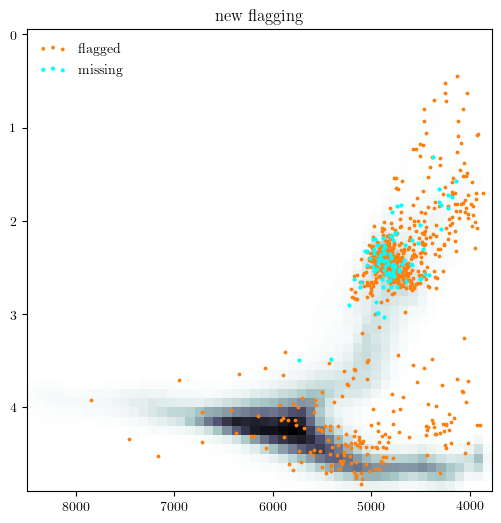

PyObject <matplotlib.legend.Legend object at 0x175b01780>

In [357]:
#axs = subplots(1, 2, figsize=(10, 4))[2]
#for (i, (k, df)) in enumerate(dfs)
#    sca(axs[i])
    #title("$k  = $(sum(df.match)) stars")
figure(figsize=(6, 6))
title("new flagging")
plt.hist2d(df.teff, df.logg, cmap="bone_r", bins=50, zorder=-1)#, norm=LogNorm())
scatter(df[df.flagged, :teff], df[df.flagged, :logg], s=3, c="C1", label="flagged")
mask = df.inbat .& (.! df.flagged)
scatter(df[mask, :teff], df[mask, :logg], s=4, c="cyan", label="missing")
#xlim(3600, 6000)
#ylim(0,4)
gca().invert_yaxis()
gca().invert_xaxis()
#end
legend()


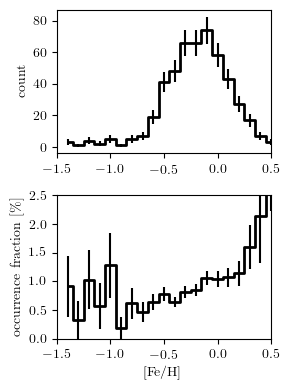

In [264]:
using StatsBase
#df = dfs["r"]
fehbins=-1.5:0.1:0.5

gmatch = df.flagged .& (df.logg .< 3)

axs = subplots(2, 1, figsize=(3,4))[2]

h = fit(Histogram, df[gmatch, :feh], fehbins)
h2 = fit(Histogram, df[df.couldflag .& (df.logg .< 3), :feh], fehbins)
midpoints = h.edges[1][1:end-1] + diff(h.edges[1])

sca(axs[1])
plt.errorbar(midpoints, h.weights, sqrt.(h.weights), ls="", c="k")
plt.step(midpoints, h.weights, where="mid", lw=2, c="k")
ylabel("count")
xlim(-1.5, 0.5)

sca(axs[2])
plt.errorbar(midpoints, h.weights./h2.weights * 100, 
    sqrt.(h.weights .+ h.weights.^2 ./ h2.weights)./h2.weights * 100, ls="", c="k")
plt.step(midpoints, h.weights./h2.weights * 100 , lw=2, where="mid", c="k")
ylabel("occurrence fraction [\\%]")
xlabel("[Fe/H]")
xlim(-1.5, 0.5)
ylim(0, 2.5)
tight_layout()
savefig("../../Desktop/occurance_rate.pdf", bbox_inches="tight")

# look at spectra

In [65]:
wl_grid = load("wl_grid.jld2")["wl_grid"]
Δλ = 7                                                                          
    
li_air = 6707.85
include("air_vacuum.jl")
li_vac = air_to_vac(li_air)
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ
;

In [216]:
ϕ(x, μ, σ) = exp(-1/2 * (x-μ)^2/σ^2) / sqrt(2π) / σ
n = sum(line_mask)
M = zeros(2 + n, n)                                                         
M[1, :] = ϕ.(wl_grid[line_mask], li_vac, li_air/3600)
M[2, :] .= sqrt(1/n)
for i in 3:(2+n)
    M[i, i-2] = 1.
end 

In [217]:
Mp = M
n = sum(line_mask)
M = zeros(2 + n, n)                                                                            
ϕ(x, μ, σ) = exp(-1/2 * (x-μ)^2/σ^2) / sqrt(2π) / σ #gaussian kernel
M[1, :] = ϕ.(wl_grid[line_mask], li_vac, li_air/3600) 
M[2, :] .= 1.0 
for i in 3:(2+n)
    M[i, i-2] = 1.
end 

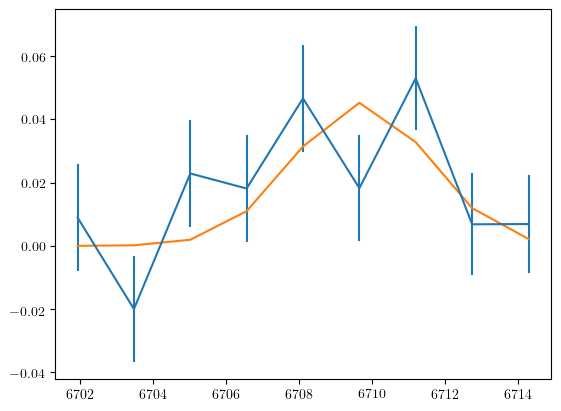

0.2114367432128439
[-15.6516, -10.3207, -0.280562, -1.41359, -1.83639, -1.13551, -7.61439, -1.17703, -10.3406, -0.179208, -0.197258]
8.525149208084828
loss: -15.651561376869568
EEW: 0.2114367432128439 ± 0.053444328698203585


In [355]:
i = rand(findall((.! df.oldflagged) .& (df.flagged)))
errorbar(wl_grid[line_mask], df[i, :diff], yerr=df[i, :err].^(-1/2))
plot(wl_grid[line_mask], df[i, :EEW] .* M[1, :])
println(df.EEW[i])
println(df.loss[i])

println(sum((df.EEW[i] .* M[1, :] .- df.diff[i]).^2 .* df.err[i]))

l1 = sum(M[1, :].^2 .* df.err[i])
l2 = sum(M[1, :] .* df.diff[i] .* df.err[i])

println("loss: $(df.loss[i][1])")
println("EEW: $(df.EEW[i]) ± $(df.EEW_err[i])")

In [238]:
RV_precision = 5e3
c = 3e8
RV_precision / c * li_air

0.11179750000000001

In [234]:
include("air_vacuum.jl")

vac_to_air (generic function with 1 method)

In [236]:
vac_to_air(6708)

6706.148469017388

In [2]:
function plot_spectrum(row)
    
    print("obsid: ", row.obsid)
    println(" ... in the battery? $(row.obsid in battery)")
    
    download_lamost_spectra([row.obsid], verbose=false)
    wl, flux, ivar = load_lamost_spectrum(row.obsid)
    download_lamost_spectra(row.neighbors, verbose=false)
    F = hcat((n->load_lamost_spectrum(n)[2]).(row.neighbors)...)
    
    #figure(figsize=(3,3))
    #ylabel("residuals")
    #xlabel(L"$\lambda$ [\AA]")
    #errorbar(wl[line_mask], row.diff, yerr=row.err, label="data")
    #errorbar(wl[line_mask], M[1, :]*row.amplitude, label="best fit line model")
    #legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    plt.plot(wl, flux, label="data")
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl, flux, yerr=ivar.^(-1/2), label="data");
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    errorbar(wl[line_mask], F[line_mask, :] * row.weights .- M[1, :]*row.amplitude, label="best fit residual model")
    legend()
    xlim(6660, 6750)
    ylim(0.9, 1.1)
    
    ;
end

LoadError: UndefVarError: @L_str not defined

[-363.421, -124.215, -0.0012058, -7.21982, -0.0116285, -3.42332, -90.9875, -183.355, -85.8909, -4.89994, -0.0180588]
180.06580724294778
obsid: 363305015 ... in the battery? false
of 1 spectra, 0 need to be downloaded


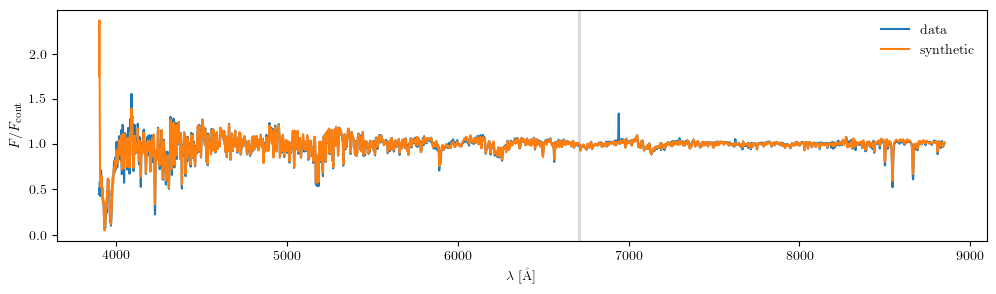

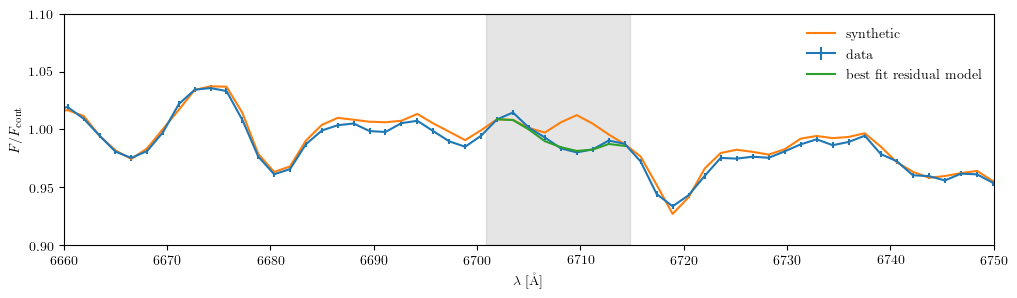

of 6 spectra, 0 need to be downloaded


(0.9, 1.1)

In [65]:
#ind = Set(dfs["ds"].obsid[dfs["ds"].match])
#i = findall(dfs["r"].match .& (.! [o in ind for o in dfs["r"].obsid]))[5]
i = findall(dfs["ds"].match)[1]
    
df = dfs["ds"]
println(df[i, :loss])
println(df[i, :delta_chi2])
plot_spectrum(df[i, :])

[-363.421, -124.215, -0.0012058, -7.21982, -0.0116285, -3.42332, -90.9875, -183.355, -85.8909, -4.89994, -0.0180588]
180.06580724294778
obsid: 363305015 ... in the battery? false
of 1 spectra, 0 need to be downloaded


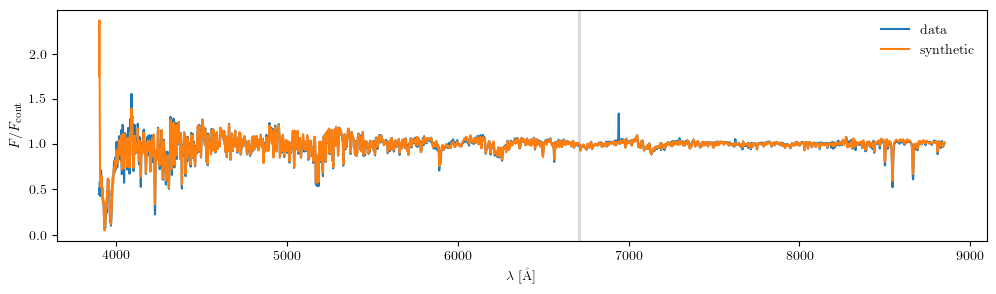

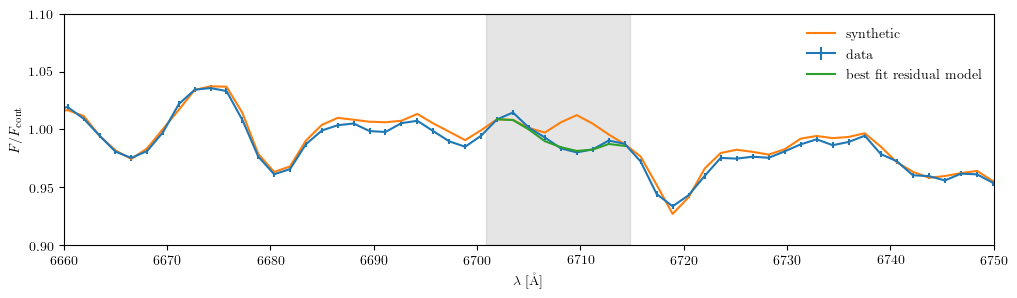

of 6 spectra, 0 need to be downloaded


(0.9, 1.1)

In [65]:
#ind = Set(dfs["ds"].obsid[dfs["ds"].match])
#i = findall(dfs["r"].match .& (.! [o in ind for o in dfs["r"].obsid]))[5]
i = findall(dfs["ds"].match)[1]
    
df = dfs["ds"]
println(df[i, :loss])
println(df[i, :delta_chi2])
plot_spectrum(df[i, :])